In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import classification_report

# Paths to the dataset
labeled_images_folder = 'D:/New CX/CXR8/images/Dest'  # Adjust this to the actual folder where your images are stored
labels_csv = 'D:/New CX/CXR8/Data_Entry_2017_v2020.csv'  # Path to the CSV file containing labels

# Load the labels CSV file
df = pd.read_csv(labels_csv)

# Filter the dataframe for the diseases of interest
diseases = ['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
            'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis',
            'Hernia', 'Pleural_Thickening', 'No Finding']

# Create a new column for single-label classification
df['Finding Labels'] = df['Finding Labels'].apply(lambda x: x.split('|')[0] if '|' in x else x)

# Filter for the diseases of interest
df = df[df['Finding Labels'].isin(diseases)]

In [2]:
# Split the dataset into training, validation, and test sets
train_df, temp_df = train_test_split(df, test_size=0.3, stratify=df['Finding Labels'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.67, stratify=temp_df['Finding Labels'], random_state=42)

# Data generators with augmentation for training, validation, and testing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=30,  # Increased rotation range
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='nearest'  # Added fill_mode for augmentation
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Flow from dataframe for training, validation, and testing generators
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=labeled_images_folder,
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(224, 224),  # Increased target size
    batch_size=32,
    class_mode='categorical'
)

validation_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=labeled_images_folder,
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(224, 224),  # Increased target size
    batch_size=32,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=labeled_images_folder,
    x_col='Image Index',
    y_col='Finding Labels',
    target_size=(224, 224),  # Increased target size
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # Important to keep the order for evaluation
)

Found 78484 validated image filenames belonging to 15 classes.
Found 11099 validated image filenames belonging to 15 classes.
Found 22537 validated image filenames belonging to 15 classes.


In [5]:
# Load pre-trained EfficientNetV2B0
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze more layers in the base model for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)  # Adding dropout for regularization
x = Dense(512, activation='relu')(x)  # Increased units in Dense layer
x = Dropout(0.5)(x)  # Adding another dropout layer
predictions = Dense(len(diseases), activation='softmax')(x)

# Define the model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model using Adam optimizer with a lower learning rate
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction and early stopping callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=0.0001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)


In [6]:
# Train the model with increased epochs and callbacks
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=50,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[reduce_lr, early_stopping]
)

Epoch 1/50
2453/2453 [==============================] - 2193s 891ms/step - loss: 1.6330 - accuracy: 0.5366 - val_loss: 1.8635 - val_accuracy: 0.5383 - lr: 0.0010
Epoch 2/50
2453/2453 [==============================] - 2168s 884ms/step - loss: 1.5598 - accuracy: 0.5419 - val_loss: 2.1513 - val_accuracy: 0.5383 - lr: 0.0010
Epoch 3/50
2453/2453 [==============================] - 2158s 880ms/step - loss: 1.5266 - accuracy: 0.5454 - val_loss: 1.9397 - val_accuracy: 0.5383 - lr: 0.0010
Epoch 4/50
2453/2453 [==============================] - ETA: 0s - loss: 1.5108 - accuracy: 0.5470
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
2453/2453 [==============================] - 2156s 879ms/step - loss: 1.5108 - accuracy: 0.5470 - val_loss: 2.2519 - val_accuracy: 0.5383 - lr: 0.0010
Epoch 5/50
2453/2453 [==============================] - 2159s 880ms/step - loss: 1.4535 - accuracy: 0.5527 - val_loss: 2.0978 - val_accuracy: 0.5383 - lr: 1.0000e-04
Epoch 6/50
2453/2453 [

705/705 [==============================] - 345s 490ms/step - loss: 1.5457 - accuracy: 0.5425
Test Accuracy: 0.5425300598144531
705/705 [==============================] - 264s 372ms/step


d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Application Installed\anacondaa\envs\sheakh310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metr

                    precision    recall  f1-score   support

       Atelectasis       0.39      0.03      0.05      2321
      Cardiomegaly       0.40      0.00      0.01       483
     Consolidation       0.00      0.00      0.00       669
             Edema       0.00      0.00      0.00       375
          Effusion       0.48      0.04      0.08      1616
         Emphysema       0.29      0.03      0.06       348
          Fibrosis       0.00      0.00      0.00       244
            Hernia       0.00      0.00      0.00        32
      Infiltration       0.00      0.00      0.00      2371
              Mass       0.31      0.01      0.02       588
        No Finding       0.54      0.99      0.70     12133
            Nodule       0.00      0.00      0.00       605
Pleural_Thickening       0.00      0.00      0.00       245
         Pneumonia       0.00      0.00      0.00        65
      Pneumothorax       0.00      0.00      0.00       442

          accuracy                    

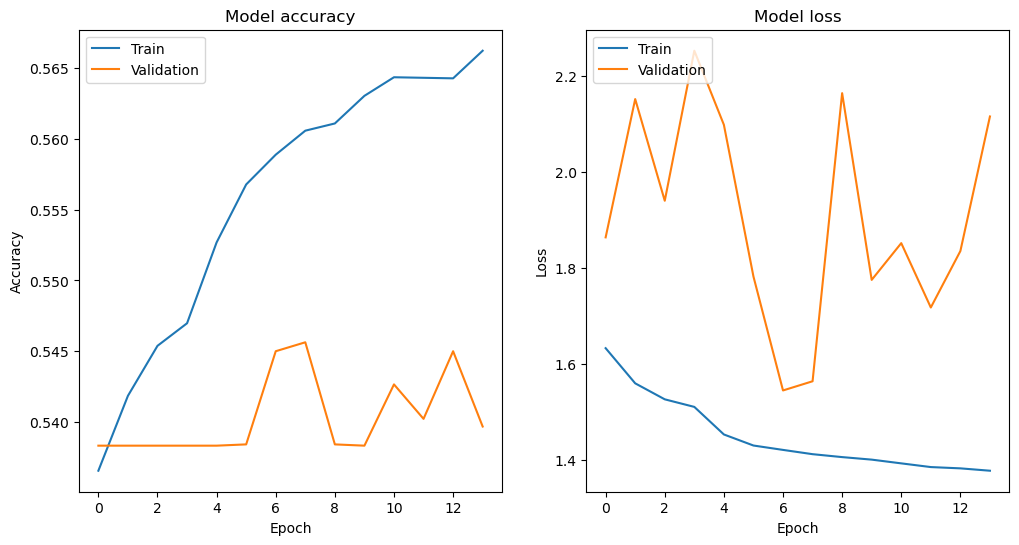

In [7]:
# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc}")

# Predict on the test set
test_generator.reset()
predictions = model.predict(test_generator)
true_labels = test_generator.classes
predicted_labels = np.argmax(predictions, axis=1)
class_labels = list(test_generator.class_indices.keys())
true_labels = [class_labels[i] for i in true_labels]
predicted_labels = [class_labels[i] for i in predicted_labels]

# Print a classification report
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()